In [63]:
import os
import spectral
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

%matplotlib inline
os.environ['KERAS_BACKEND']='tensorflow'

from operator import truediv
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Dropout, Input
from keras.optimizers.legacy import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization

import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.python.keras.utils import np_utils
utils.to_categorical

<function keras.src.utils.np_utils.to_categorical(y, num_classes=None, dtype='float32')>

In [64]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 25 #patch size

In [65]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [113]:
x, y = loadData(dataset)
x.shape, y.shape

((145, 145, 200), (145, 145))

(145, 145)


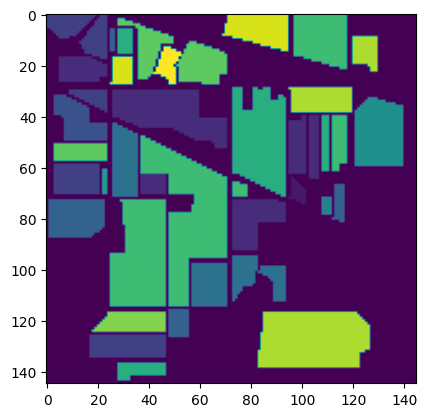

In [114]:
plt.imshow(y)
print(y.shape)

(145, 200)


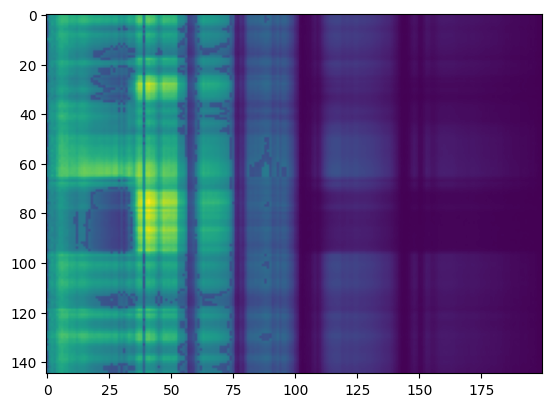

In [115]:
plt.imshow(x[0])
print(x[0].shape)

In [116]:
x[11][12].shape

(200,)

In [117]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    print(newX.shape)
    pca = PCA(n_components=numComponents, whiten=True)   
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [118]:
K = 30 if dataset == 'IP' else 15
print("before pca : ",x.shape)
x,pca = applyPCA(x,numComponents=K)   # reduced dimention using PCA  from ((145, 145, 200) -> (145, 145, 30))
print("after pca : ",x.shape)

before pca :  (145, 145, 200)
(21025, 200)
after pca :  (145, 145, 30)


(145, 30)


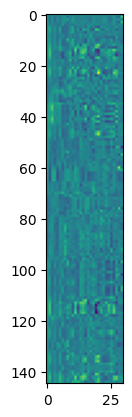

In [119]:
plt.imshow(x[0])
print(x[0].shape)

In [120]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [121]:
def createImageCubes(x, y, windowSize=5, removeZeroLabels = True):
    
    margin = int((windowSize - 1) / 2)
    print("window_size : ", windowSize)
    print("margin : ", margin)
    print("before padding shape : ",x.shape)
    zeroPaddedx = padWithZeros(x, margin=margin)
    print("after padding shape : ",zeroPaddedx.shape)
    # split patches
    
    patchesData = np.zeros((x.shape[0] * x.shape[1], windowSize, windowSize, x.shape[2]))
    patchesLabels = np.zeros((x.shape[0] * x.shape[1]))
    print("patchesData shape : " , patchesData.shape)
    print("patchesLabels shape : " , patchesLabels.shape)
    
    patchIndex = 0
    for r in range(margin, zeroPaddedx.shape[0] - margin):
        for c in range(margin, zeroPaddedx.shape[1] - margin):
            patch = zeroPaddedx[r - margin:r + margin + 1, c - margin:c + margin + 1]    # obtaining patches
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1

    print("patchesData shape before removing zerolabels : " , patchesData.shape)
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    print("patchesData shape after removing zerolabels : " , patchesData.shape)
    return patchesData, patchesLabels

In [122]:
# creating patches
x, y = createImageCubes(x, y, windowSize=windowSize)
x.shape, y.shape

window_size :  25
margin :  12
before padding shape :  (145, 145, 30)
after padding shape :  (169, 169, 30)
patchesData shape :  (21025, 25, 25, 30)
patchesLabels shape :  (21025,)
patchesData shape before removing zerolabels :  (21025, 25, 25, 30)
patchesData shape after removing zerolabels :  (10249, 25, 25, 30)


((10249, 25, 25, 30), (10249,))

(25, 30)


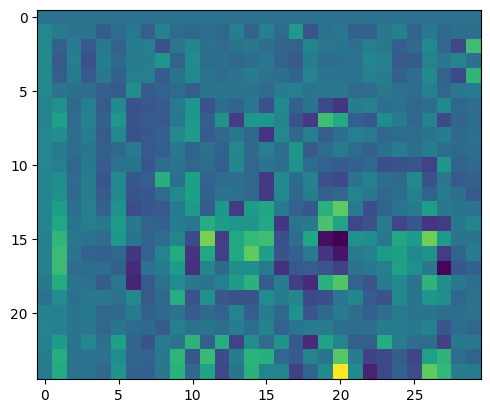

In [123]:
plt.imshow(x[11][12])
print(x[11][12].shape)

In [124]:
# function to split dataset into test and training dataset
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,stratify=y)
    return X_train, X_test, y_train, y_test

In [125]:
xtrain, xtest, ytrain, ytest = splitTrainTestSet(x, y, test_ratio)
print("xtrain shape : ",xtrain.shape)
print("xtest shape : ",xtest.shape)
print("ytrain shape : ",ytrain.shape)
print("ytest shape : ",ytest.shape)

xtrain shape :  (3074, 25, 25, 30)
xtest shape :  (7175, 25, 25, 30)
ytrain shape :  (3074,)
ytest shape :  (7175,)


In [126]:
xtrain = xtrain.reshape(-1, windowSize, windowSize, K, 1)
xtrain.shape

(3074, 25, 25, 30, 1)

In [127]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

In [81]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16   # output class no = 16 for "IP"

In [82]:
# hybridSN model

## input layer
input_layer = Input((S, S, L, 1))
print("input_layer shape : " , input_layer.shape)


## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print("3D_conv_layer_1 shape : ", conv_layer1.shape)
print("3D_conv_layer_2 shape : ", conv_layer2.shape)
print("3D_conv_layer_3 shape : ", conv_layer3.shape)


conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
print("Reshaped_3D_conv_layer_3 shape : ", conv_layer3.shape)
print("2D_conv_layer_1 shape : ", conv_layer4.shape)


flatten_layer = Flatten()(conv_layer4)
print("flatten_layer shape : ", flatten_layer.shape)


## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)
print("output_layer shape : ", output_layer.shape)
# Sigmoid is used for binary classification methods where we only have 2 classes, while SoftMax applies to multiclass 

input_layer shape :  (None, 25, 25, 30, 1)
3D_conv_layer_1 shape :  (None, 23, 23, 24, 8)
3D_conv_layer_2 shape :  (None, 21, 21, 20, 16)
3D_conv_layer_3 shape :  (None, 19, 19, 18, 32)
Reshaped_3D_conv_layer_3 shape :  (None, 19, 19, 576)
2D_conv_layer_1 shape :  (None, 17, 17, 64)
flatten_layer shape :  (None, 18496)
output_layer shape :  (None, 16)


In [83]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [84]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv3d_12 (Conv3D)          (None, 23, 23, 24, 8)     512       
                                                                 
 conv3d_13 (Conv3D)          (None, 21, 21, 20, 16)    5776      
                                                                 
 conv3d_14 (Conv3D)          (None, 19, 19, 18, 32)    13856     
                                                                 
 reshape_4 (Reshape)         (None, 19, 19, 576)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 17, 17, 64)        331840    
                                                                 
 flatten_4 (Flatten)         (None, 18496)             0   

In [85]:
# compiling the model
adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [86]:
# checkpoint
filepath = "best-model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',save_best_only=True, verbose=1, mode='max')
callbacks_list = [checkpoint]

In [87]:
history = model.fit(x=xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
13/13 [==============================] - 51s 4s/step - loss: 2.7638 - accuracy: 0.1854
Epoch 2/100
13/13 [==============================] - 50s 4s/step - loss: 2.4418 - accuracy: 0.2075
Epoch 3/100
13/13 [==============================] - 50s 4s/step - loss: 2.1207 - accuracy: 0.2876
Epoch 4/100
13/13 [==============================] - 201s 16s/step - loss: 1.6617 - accuracy: 0.4317
Epoch 5/100
13/13 [==============================] - 57s 4s/step - loss: 1.2863 - accuracy: 0.5530
Epoch 6/100
13/13 [==============================] - 63s 5s/step - loss: 0.9349 - accuracy: 0.6851
Epoch 7/100
13/13 [==============================] - 53s 4s/step - loss: 0.7252 - accuracy: 0.7716
Epoch 8/100
13/13 [==============================] - 56s 4s/step - loss: 0.5504 - accuracy: 0.8208
Epoch 9/100
13/13 [==============================] - 54s 4s/step - loss: 0.4082 - accuracy: 0.8663
Epoch 10/100
13/13 [==============================] - 55s 4s/step - loss: 0.3301 - accuracy: 0.8959
Epoch 1

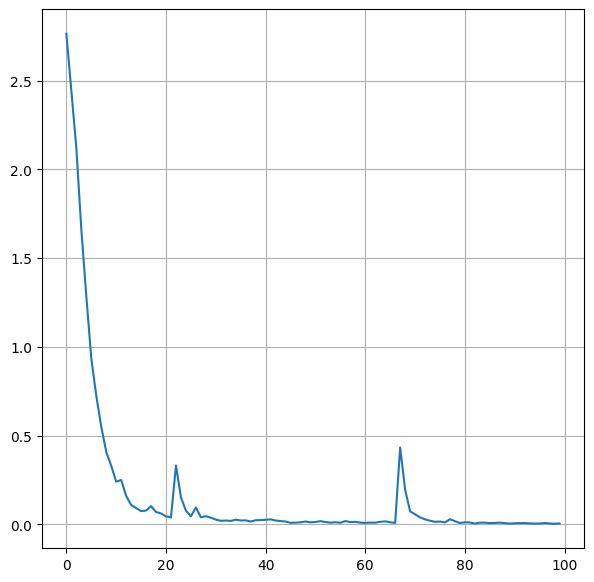

In [88]:
plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])

In [90]:
# load best weights
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [128]:
xtest = xtest.reshape(-1, windowSize, windowSize, K, 1)
xtest.shape

(7175, 25, 25, 30, 1)

In [129]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(7175, 16)

In [130]:
Y_pred_test = model.predict(xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)
y_pred_test.shape

225/225 [==============================] - 22s 99ms/step


(7175,)

In [131]:
classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       0.97      0.97      0.97      1000
           2       1.00      0.99      0.99       581
           3       1.00      0.96      0.98       166
           4       0.99      1.00      0.99       338
           5       0.99      1.00      1.00       511
           6       1.00      0.95      0.97        20
           7       1.00      1.00      1.00       335
           8       1.00      0.93      0.96        14
           9       0.99      1.00      1.00       680
          10       0.99      1.00      0.99      1719
          11       0.97      0.97      0.97       415
          12       1.00      0.99      0.99       143
          13       1.00      1.00      1.00       886
          14       1.00      1.00      1.00       270
          15       1.00      0.83      0.91        65

    accuracy                           0.99      7175
   macro avg       0.99   

In [132]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [133]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [136]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

225/225 [==============================] - 23s 103ms/step - loss: 0.0374 - accuracy: 0.9886


In [137]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [138]:
# load the original image
X, y = loadData(dataset)

In [139]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [140]:
X,pca = applyPCA(X, numComponents=numComponents)

(21025, 200)


In [141]:
X = padWithZeros(X, PATCH_SIZE//2)

In [142]:
height,width

(145, 145)

In [143]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

1/1 [==============================] - 0s 14ms/step


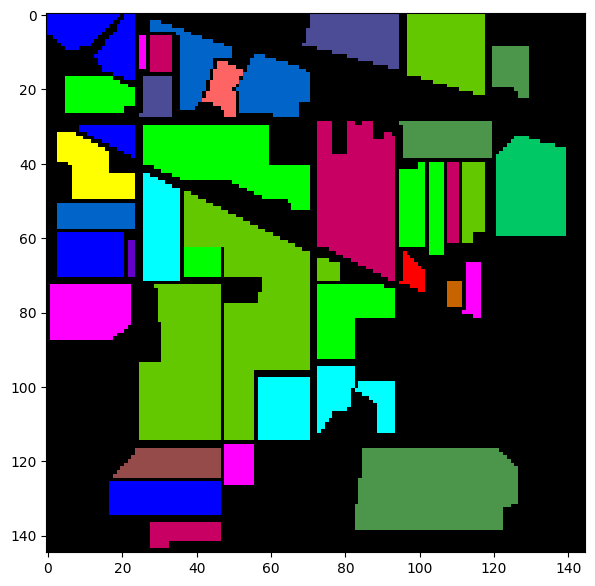

In [147]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

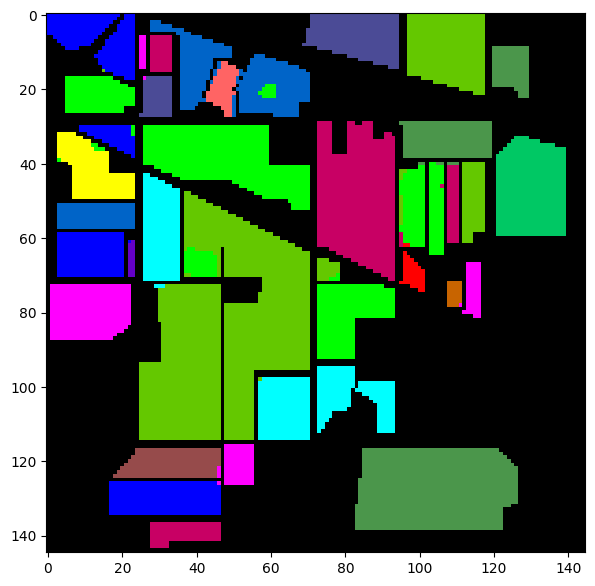

In [148]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))